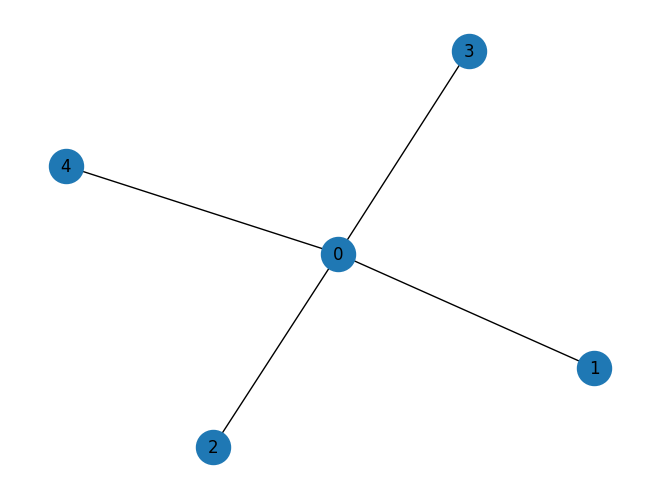

In [8]:
import rustworkx as rx
from rustworkx.visualization import mpl_draw as draw_graph
import numpy as np

n = 5

graph = rx.PyGraph()
graph.add_nodes_from(np.arange(0, n, 1))
edge_list = [(0, 1, 1.0), (0, 2, 1.0), (0, 3, 1.0), (0, 4, 1.0)]
graph.add_edges_from(edge_list)
draw_graph(graph, node_size=600, with_labels=True)

In [9]:
from qiskit.quantum_info import SparsePauliOp
def build_max_cut_paulis(graph: rx.PyGraph) -> list[tuple[str, float]]:
    """Convert the graph to Pauli list.

    This function does the inverse of `build_max_cut_graph`
    """
    pauli_list = []
    for edge in list(graph.edge_list()):
        paulis = ["I"] * len(graph)
        paulis[edge[0]], paulis[edge[1]] = "Z", "Z"

        weight = graph.get_edge_data(edge[0], edge[1])

        pauli_list.append(("".join(paulis)[::-1], weight))

    return pauli_list


max_cut_paulis = build_max_cut_paulis(graph)

cost_hamiltonian = SparsePauliOp.from_list(max_cut_paulis)
print("Cost Function Hamiltonian:", cost_hamiltonian)

Cost Function Hamiltonian: SparsePauliOp(['IIIZZ', 'IIZIZ', 'IZIIZ', 'ZIIIZ'],
              coeffs=[1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j])


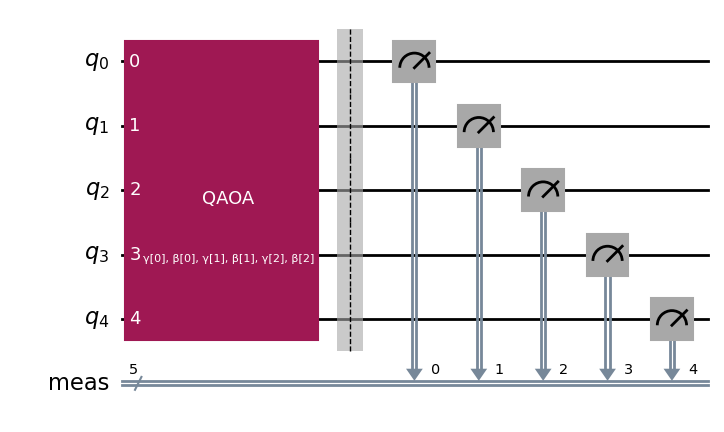

In [10]:
from qiskit.circuit.library import QAOAAnsatz

depth_circuit = 3
circuit = QAOAAnsatz(cost_operator=cost_hamiltonian, reps=depth_circuit)
circuit.measure_all()

circuit.draw('mpl')

AerSimulator('aer_simulator')


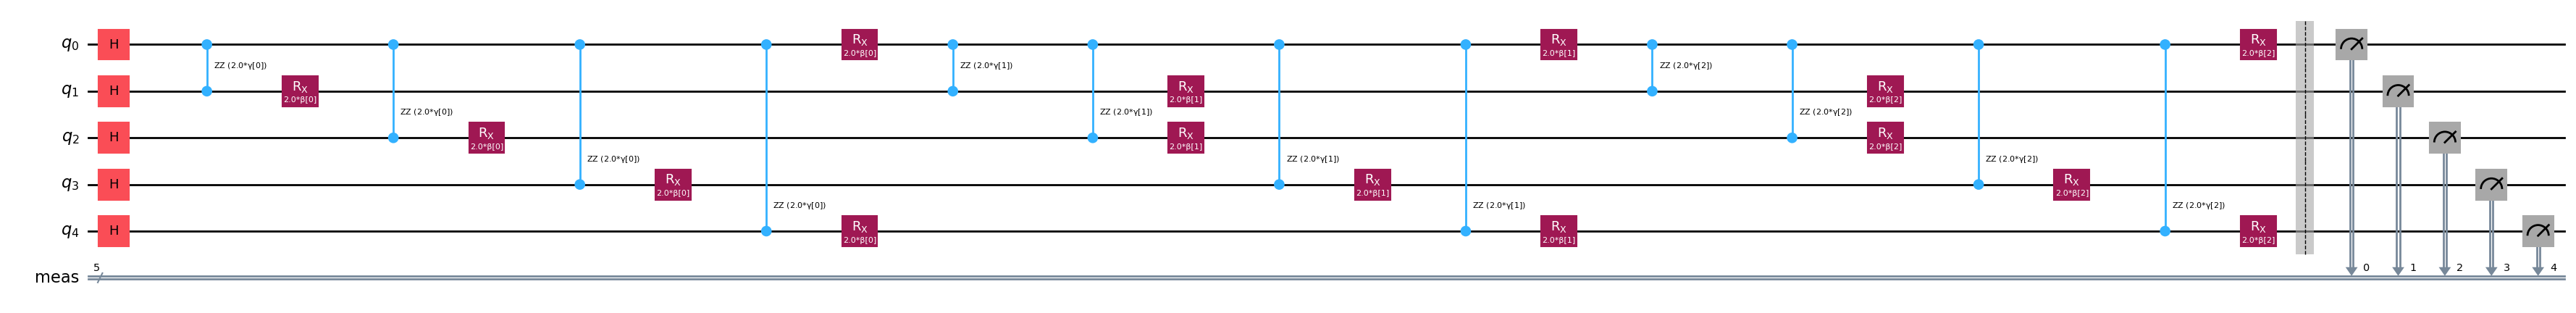

In [11]:
#from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_aer import AerSimulator
backend = AerSimulator()


# QiskitRuntimeService.save_account(channel="ibm_quantum", token="<MY_IBM_QUANTUM_TOKEN>", overwrite=True, set_as_default=True)
#service = QiskitRuntimeService(channel='ibm_quantum')
#backend = service.least_busy(min_num_qubits=127)
print(backend)

# Create pass manager for transpilation
pm = generate_preset_pass_manager(optimization_level=0,
                                    backend=backend)

candidate_circuit = pm.run(circuit)
candidate_circuit.draw('mpl', fold=False, idle_wires=False)

In [12]:
initial_gamma = np.pi
initial_beta = np.pi/2
init_params = []
for i in range(depth_circuit):
    init_params.append(initial_gamma)
    init_params.append(initial_beta)

print(init_params)

[3.141592653589793, 1.5707963267948966, 3.141592653589793, 1.5707963267948966, 3.141592653589793, 1.5707963267948966]


In [13]:
def cost_func_estimator(params, ansatz, hamiltonian, estimator):

    # transform the observable defined on virtual qubits to
    # an observable defined on all physical qubits
    isa_hamiltonian = hamiltonian.apply_layout(ansatz.layout)

    pub = (ansatz, isa_hamiltonian, params)
    job = estimator.run([pub])

    results = job.result()[0]
    cost = results.data.evs
    print("cost is " + str(cost))
    objective_func_vals.append(cost)


    return cost

In [14]:
from qiskit_ibm_runtime import Session, EstimatorV2 as Estimator
from scipy.optimize import minimize

objective_func_vals = [] # Global variable
with Session(backend=backend) as session:
    # If using qiskit-ibm-runtime<0.24.0, change `mode=` to `session=`
    estimator = Estimator(mode=session)
    estimator.options.default_shots = 1000

    # Set simple error suppression/mitigation options
    estimator.options.dynamical_decoupling.enable = True
    estimator.options.dynamical_decoupling.sequence_type = "XY4"
    estimator.options.twirling.enable_gates = True
    estimator.options.twirling.num_randomizations = "auto"

    result = minimize(
        cost_func_estimator,
        init_params,
        args=(candidate_circuit, cost_hamiltonian, estimator),
        method="COBYLA",
        tol=1e-2,
    )
    print(result)

/home/ale/documents/qiskit/.venv/lib/python3.10/site-packages/qiskit_ibm_runtime/fake_provider/local_service.py:234: UserWarning: Options {'dynamical_decoupling': {'enable': True, 'sequence_type': 'XY4'}, 'twirling': {'enable_gates': True, 'num_randomizations': 'auto'}} have no effect in local testing mode.
  warnings.warn(f"Options {options_copy} have no effect in local testing mode.")
/home/ale/documents/qiskit/.venv/lib/python3.10/site-packages/qiskit_ibm_runtime/fake_provider/local_service.py:234: UserWarning: Options {'dynamical_decoupling': {'enable': True, 'sequence_type': 'XY4'}, 'twirling': {'enable_gates': True, 'num_randomizations': 'auto'}} have no effect in local testing mode.
  warnings.warn(f"Options {options_copy} have no effect in local testing mode.")
/home/ale/documents/qiskit/.venv/lib/python3.10/site-packages/qiskit_ibm_runtime/fake_provider/local_service.py:234: UserWarning: Options {'dynamical_decoupling': {'enable': True, 'sequence_type': 'XY4'}, 'twirling': {'e

cost is 0.06393606393606394
cost is -0.03396603396603397
cost is -0.16183816183816183
cost is -0.02597402597402597
cost is -1.906093906093906


/home/ale/documents/qiskit/.venv/lib/python3.10/site-packages/qiskit_ibm_runtime/fake_provider/local_service.py:234: UserWarning: Options {'dynamical_decoupling': {'enable': True, 'sequence_type': 'XY4'}, 'twirling': {'enable_gates': True, 'num_randomizations': 'auto'}} have no effect in local testing mode.
  warnings.warn(f"Options {options_copy} have no effect in local testing mode.")
/home/ale/documents/qiskit/.venv/lib/python3.10/site-packages/qiskit_ibm_runtime/fake_provider/local_service.py:234: UserWarning: Options {'dynamical_decoupling': {'enable': True, 'sequence_type': 'XY4'}, 'twirling': {'enable_gates': True, 'num_randomizations': 'auto'}} have no effect in local testing mode.
  warnings.warn(f"Options {options_copy} have no effect in local testing mode.")
/home/ale/documents/qiskit/.venv/lib/python3.10/site-packages/qiskit_ibm_runtime/fake_provider/local_service.py:234: UserWarning: Options {'dynamical_decoupling': {'enable': True, 'sequence_type': 'XY4'}, 'twirling': {'e

cost is -0.939060939060939
cost is -1.9520479520479521
cost is 1.4005994005994005


/home/ale/documents/qiskit/.venv/lib/python3.10/site-packages/qiskit_ibm_runtime/fake_provider/local_service.py:234: UserWarning: Options {'dynamical_decoupling': {'enable': True, 'sequence_type': 'XY4'}, 'twirling': {'enable_gates': True, 'num_randomizations': 'auto'}} have no effect in local testing mode.
  warnings.warn(f"Options {options_copy} have no effect in local testing mode.")
/home/ale/documents/qiskit/.venv/lib/python3.10/site-packages/qiskit_ibm_runtime/fake_provider/local_service.py:234: UserWarning: Options {'dynamical_decoupling': {'enable': True, 'sequence_type': 'XY4'}, 'twirling': {'enable_gates': True, 'num_randomizations': 'auto'}} have no effect in local testing mode.
  warnings.warn(f"Options {options_copy} have no effect in local testing mode.")
/home/ale/documents/qiskit/.venv/lib/python3.10/site-packages/qiskit_ibm_runtime/fake_provider/local_service.py:234: UserWarning: Options {'dynamical_decoupling': {'enable': True, 'sequence_type': 'XY4'}, 'twirling': {'e

cost is -0.6453546453546454
cost is -1.004995004995005
cost is 1.5004995004995005


/home/ale/documents/qiskit/.venv/lib/python3.10/site-packages/qiskit_ibm_runtime/fake_provider/local_service.py:234: UserWarning: Options {'dynamical_decoupling': {'enable': True, 'sequence_type': 'XY4'}, 'twirling': {'enable_gates': True, 'num_randomizations': 'auto'}} have no effect in local testing mode.
  warnings.warn(f"Options {options_copy} have no effect in local testing mode.")
/home/ale/documents/qiskit/.venv/lib/python3.10/site-packages/qiskit_ibm_runtime/fake_provider/local_service.py:234: UserWarning: Options {'dynamical_decoupling': {'enable': True, 'sequence_type': 'XY4'}, 'twirling': {'enable_gates': True, 'num_randomizations': 'auto'}} have no effect in local testing mode.
  warnings.warn(f"Options {options_copy} have no effect in local testing mode.")
/home/ale/documents/qiskit/.venv/lib/python3.10/site-packages/qiskit_ibm_runtime/fake_provider/local_service.py:234: UserWarning: Options {'dynamical_decoupling': {'enable': True, 'sequence_type': 'XY4'}, 'twirling': {'e

cost is 0.07392607392607393
cost is 0.45154845154845163
cost is -0.6673326673326674
cost is -1.928071928071928
cost is -0.933066933066933
cost is -1.5644355644355645
cost is -2.145854145854146
cost is -2.4335664335664333


/home/ale/documents/qiskit/.venv/lib/python3.10/site-packages/qiskit_ibm_runtime/fake_provider/local_service.py:234: UserWarning: Options {'dynamical_decoupling': {'enable': True, 'sequence_type': 'XY4'}, 'twirling': {'enable_gates': True, 'num_randomizations': 'auto'}} have no effect in local testing mode.
  warnings.warn(f"Options {options_copy} have no effect in local testing mode.")
/home/ale/documents/qiskit/.venv/lib/python3.10/site-packages/qiskit_ibm_runtime/fake_provider/local_service.py:234: UserWarning: Options {'dynamical_decoupling': {'enable': True, 'sequence_type': 'XY4'}, 'twirling': {'enable_gates': True, 'num_randomizations': 'auto'}} have no effect in local testing mode.
  warnings.warn(f"Options {options_copy} have no effect in local testing mode.")
/home/ale/documents/qiskit/.venv/lib/python3.10/site-packages/qiskit_ibm_runtime/fake_provider/local_service.py:234: UserWarning: Options {'dynamical_decoupling': {'enable': True, 'sequence_type': 'XY4'}, 'twirling': {'e

cost is -2.7132867132867133
cost is -2.7832167832167833
cost is -2.851148851148851
cost is -2.875124875124875


/home/ale/documents/qiskit/.venv/lib/python3.10/site-packages/qiskit_ibm_runtime/fake_provider/local_service.py:234: UserWarning: Options {'dynamical_decoupling': {'enable': True, 'sequence_type': 'XY4'}, 'twirling': {'enable_gates': True, 'num_randomizations': 'auto'}} have no effect in local testing mode.
  warnings.warn(f"Options {options_copy} have no effect in local testing mode.")
/home/ale/documents/qiskit/.venv/lib/python3.10/site-packages/qiskit_ibm_runtime/fake_provider/local_service.py:234: UserWarning: Options {'dynamical_decoupling': {'enable': True, 'sequence_type': 'XY4'}, 'twirling': {'enable_gates': True, 'num_randomizations': 'auto'}} have no effect in local testing mode.
  warnings.warn(f"Options {options_copy} have no effect in local testing mode.")
/home/ale/documents/qiskit/.venv/lib/python3.10/site-packages/qiskit_ibm_runtime/fake_provider/local_service.py:234: UserWarning: Options {'dynamical_decoupling': {'enable': True, 'sequence_type': 'XY4'}, 'twirling': {'e

cost is -2.7332667332667335
cost is -2.5414585414585416
cost is -2.8411588411588413
cost is -2.8291708291708293


/home/ale/documents/qiskit/.venv/lib/python3.10/site-packages/qiskit_ibm_runtime/fake_provider/local_service.py:234: UserWarning: Options {'dynamical_decoupling': {'enable': True, 'sequence_type': 'XY4'}, 'twirling': {'enable_gates': True, 'num_randomizations': 'auto'}} have no effect in local testing mode.
  warnings.warn(f"Options {options_copy} have no effect in local testing mode.")
/home/ale/documents/qiskit/.venv/lib/python3.10/site-packages/qiskit_ibm_runtime/fake_provider/local_service.py:234: UserWarning: Options {'dynamical_decoupling': {'enable': True, 'sequence_type': 'XY4'}, 'twirling': {'enable_gates': True, 'num_randomizations': 'auto'}} have no effect in local testing mode.
  warnings.warn(f"Options {options_copy} have no effect in local testing mode.")
/home/ale/documents/qiskit/.venv/lib/python3.10/site-packages/qiskit_ibm_runtime/fake_provider/local_service.py:234: UserWarning: Options {'dynamical_decoupling': {'enable': True, 'sequence_type': 'XY4'}, 'twirling': {'e

cost is -2.7512487512487516
cost is -2.857142857142857
cost is -2.6753246753246755
cost is -2.793206793206793


/home/ale/documents/qiskit/.venv/lib/python3.10/site-packages/qiskit_ibm_runtime/fake_provider/local_service.py:234: UserWarning: Options {'dynamical_decoupling': {'enable': True, 'sequence_type': 'XY4'}, 'twirling': {'enable_gates': True, 'num_randomizations': 'auto'}} have no effect in local testing mode.
  warnings.warn(f"Options {options_copy} have no effect in local testing mode.")
/home/ale/documents/qiskit/.venv/lib/python3.10/site-packages/qiskit_ibm_runtime/fake_provider/local_service.py:234: UserWarning: Options {'dynamical_decoupling': {'enable': True, 'sequence_type': 'XY4'}, 'twirling': {'enable_gates': True, 'num_randomizations': 'auto'}} have no effect in local testing mode.
  warnings.warn(f"Options {options_copy} have no effect in local testing mode.")
/home/ale/documents/qiskit/.venv/lib/python3.10/site-packages/qiskit_ibm_runtime/fake_provider/local_service.py:234: UserWarning: Options {'dynamical_decoupling': {'enable': True, 'sequence_type': 'XY4'}, 'twirling': {'e

cost is -2.801198801198801
cost is -2.8331668331668336
cost is -2.8631368631368628
cost is -2.8031968031968035


/home/ale/documents/qiskit/.venv/lib/python3.10/site-packages/qiskit_ibm_runtime/fake_provider/local_service.py:234: UserWarning: Options {'dynamical_decoupling': {'enable': True, 'sequence_type': 'XY4'}, 'twirling': {'enable_gates': True, 'num_randomizations': 'auto'}} have no effect in local testing mode.
  warnings.warn(f"Options {options_copy} have no effect in local testing mode.")
/home/ale/documents/qiskit/.venv/lib/python3.10/site-packages/qiskit_ibm_runtime/fake_provider/local_service.py:234: UserWarning: Options {'dynamical_decoupling': {'enable': True, 'sequence_type': 'XY4'}, 'twirling': {'enable_gates': True, 'num_randomizations': 'auto'}} have no effect in local testing mode.
  warnings.warn(f"Options {options_copy} have no effect in local testing mode.")
/home/ale/documents/qiskit/.venv/lib/python3.10/site-packages/qiskit_ibm_runtime/fake_provider/local_service.py:234: UserWarning: Options {'dynamical_decoupling': {'enable': True, 'sequence_type': 'XY4'}, 'twirling': {'e

cost is -2.6593406593406588
cost is -2.8351648351648353
 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -2.8351648351648353
       x: [ 4.033e+00  2.583e+00  3.399e+00  2.608e+00  3.159e+00
            2.566e+00]
    nfev: 37
   maxcv: 0.0


/home/ale/documents/qiskit/.venv/lib/python3.10/site-packages/qiskit_ibm_runtime/fake_provider/local_service.py:234: UserWarning: Options {'dynamical_decoupling': {'enable': True, 'sequence_type': 'XY4'}, 'twirling': {'enable_gates': True, 'num_randomizations': 'auto'}} have no effect in local testing mode.
  warnings.warn(f"Options {options_copy} have no effect in local testing mode.")


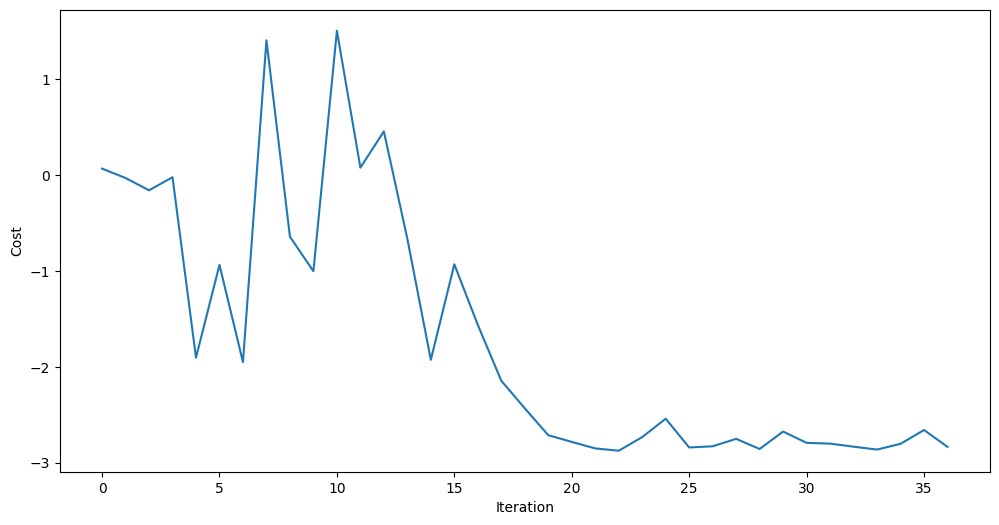

In [15]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(objective_func_vals)
plt.xlabel("Iteration")
plt.ylabel("Cost")
plt.show()

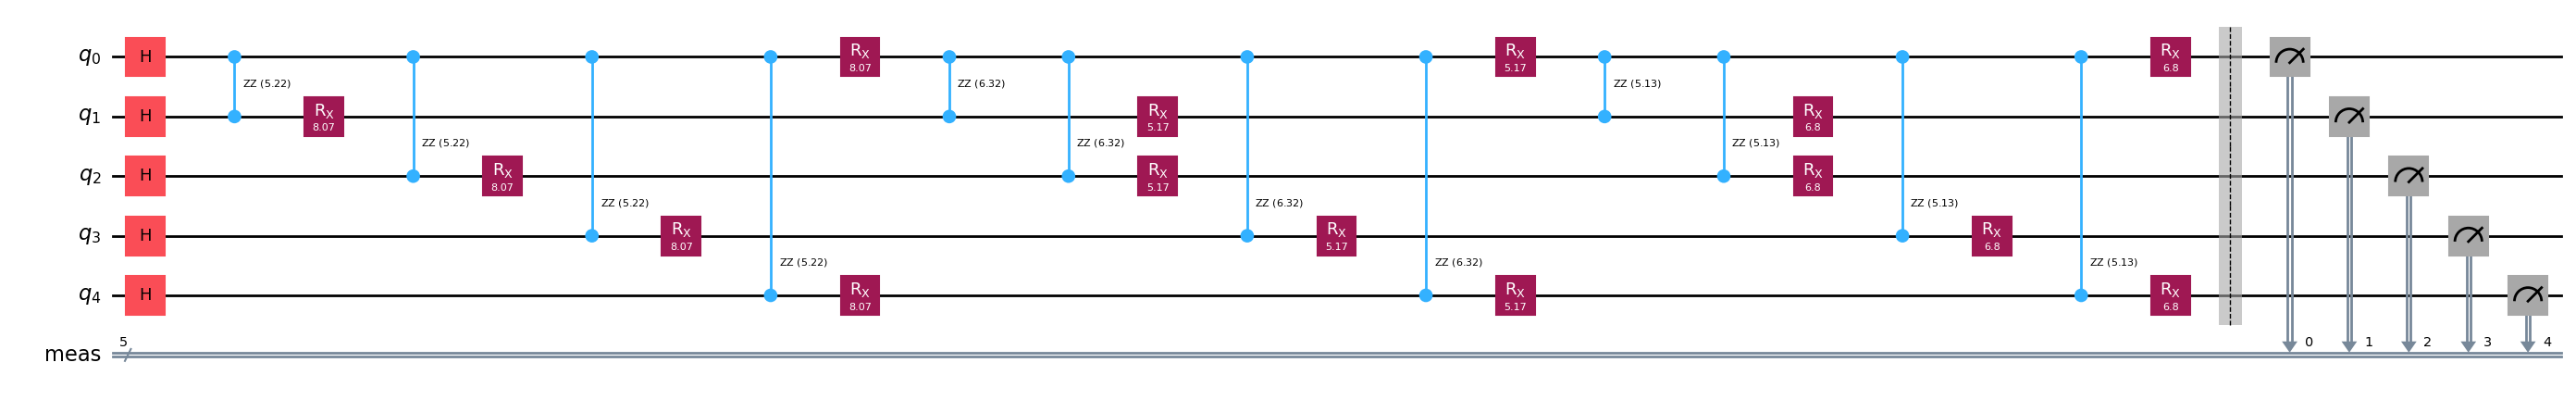

In [16]:
optimized_circuit = candidate_circuit.assign_parameters(result.x)
optimized_circuit.draw('mpl', fold=False, idle_wires=False)

In [17]:
from qiskit_ibm_runtime import SamplerV2 as Sampler

# If using qiskit-ibm-runtime<0.24.0, change `mode=` to `backend=`
sampler = Sampler(mode=backend)
sampler.options.default_shots = 10000

# Set simple error suppression/mitigation options
sampler.options.dynamical_decoupling.enable = True
sampler.options.dynamical_decoupling.sequence_type = "XY4"
sampler.options.twirling.enable_gates = True
sampler.options.twirling.num_randomizations = "auto"

pub= (optimized_circuit, )
job = sampler.run([pub], shots=int(1e4))
counts_int = job.result()[0].data.meas.get_int_counts()
counts_bin = job.result()[0].data.meas.get_counts()
shots = sum(counts_int.values())
final_distribution_int = {key: val/shots for key, val in counts_int.items()}
final_distribution_bin = {key: val/shots for key, val in counts_bin.items()}
print(final_distribution_int)

{1: 0.342, 30: 0.3404, 28: 0.0206, 15: 0.0158, 31: 0.0047, 27: 0.0162, 13: 0.0011, 5: 0.0204, 8: 0.0132, 0: 0.0048, 17: 0.0209, 22: 0.0231, 3: 0.0218, 9: 0.0248, 18: 0.0015, 24: 0.0009, 16: 0.0141, 7: 0.0009, 4: 0.0136, 14: 0.0203, 29: 0.0172, 26: 0.025, 23: 0.0144, 2: 0.0145, 19: 0.0012, 10: 0.0009, 21: 0.001, 6: 0.0015, 25: 0.0008, 11: 0.001, 12: 0.0003, 20: 0.0011}


/home/ale/documents/qiskit/.venv/lib/python3.10/site-packages/qiskit_ibm_runtime/fake_provider/local_service.py:234: UserWarning: Options {'dynamical_decoupling': {'enable': True, 'sequence_type': 'XY4'}, 'twirling': {'enable_gates': True, 'num_randomizations': 'auto'}} have no effect in local testing mode.
  warnings.warn(f"Options {options_copy} have no effect in local testing mode.")


In [18]:
# auxiliary functions to sample most likely bitstring
def to_bitstring(integer, num_bits):
    result = np.binary_repr(integer, width=num_bits)
    return [int(digit) for digit in result]

keys = list(final_distribution_int.keys())
values = list(final_distribution_int.values())
most_likely = keys[np.argmax(np.abs(values))]
most_likely_bitstring = to_bitstring(most_likely, len(graph))
most_likely_bitstring.reverse()

print("Result bitstring:", most_likely_bitstring)

Result bitstring: [1, 0, 0, 0, 0]


0
1
21
13


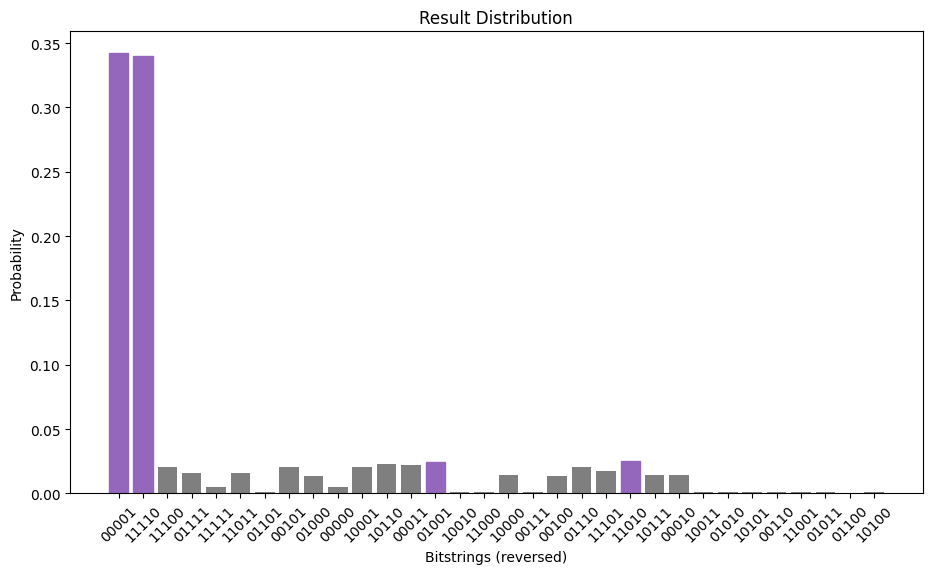

In [19]:
import matplotlib.pyplot as plt
import matplotlib

matplotlib.rcParams.update({"font.size": 10})
final_bits = final_distribution_bin
values = np.abs(list(final_bits.values()))
top_4_values = sorted(values, reverse=True)[:4]
positions = []
for value in top_4_values:
    ww = np.where(values == value)[0][0]
    print(ww)
    positions.append(ww)
fig = plt.figure(figsize=(11, 6))
ax = fig.add_subplot(1, 1, 1)
plt.xticks(rotation=45)
plt.title("Result Distribution")
plt.xlabel("Bitstrings (reversed)")
plt.ylabel("Probability")
ax.bar(list(final_bits.keys()), list(final_bits.values()), color="tab:grey")
for p in positions:
    ax.get_children()[int(p)].set_color("tab:purple")
plt.show()

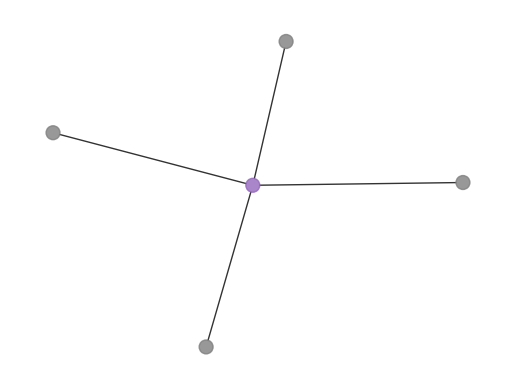

In [20]:
# auxiliary function to plot graphs
def plot_result(G, x):
    colors = ["tab:grey" if i == 0 else "tab:purple" for i in x]
    pos, default_axes = rx.spring_layout(G), plt.axes(frameon=True)
    rx.visualization.mpl_draw(G, node_color=colors, node_size=100, alpha=0.8, pos=pos)


plot_result(graph, most_likely_bitstring)

In [21]:
from typing import Sequence
def evaluate_sample(x: Sequence[int], graph: rx.PyGraph) -> float:
    assert len(x) == len(list(graph.nodes())), "The length of x must coincide with the number of nodes in the graph."
    return sum(x[u] * (1 - x[v]) + x[v] * (1 - x[u]) for u, v in list(graph.edge_list()))


cut_value= evaluate_sample(most_likely_bitstring, graph)
print('The value of the cut is:', cut_value)

The value of the cut is: 4
